In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os 

In [ ]:
import biomart
#comvert ensembl ID to gene symbol
server = biomart.BiomartServer('http://uswest.ensembl.org/biomart',mirror = "useast")    
mart = server.datasets['hsapiens_gene_ensembl']     
attributes = ['ensembl_gene_id','hgnc_symbol']
response = mart.search({'attributes': attributes})                          
data = response.raw.data.decode('ascii')  

## create a conversion table of ensembl id and gene symbol
ensembl_to_genesymbol = {}                                                  
# Store the data in a dict                                                  
for line in data.splitlines():                                              
    line = line.split('\t')                                                 
    # The entries are in the same order as in the `attributes` variable
    transcript_id = line[0]                                                 
    gene_symbol = line[1]                                                                                                
                                                                            
    # Some of these keys may be an empty string. If you want, you can 
    # avoid having a '' key in your dict by ensuring the 
    # transcript/gene/peptide ids have a nonzero length before
    # adding them to the dict
    ensembl_to_genesymbol[gene_symbol] = transcript_id    

ens_id = []
for g in hbv_gene['Gene_symbol'] :
    ens_id.append(ensembl_to_genesymbol[g])   

hbv_conversion_table = pd.DataFrame({'Gene_symbol' : hbv_gene['Gene_symbol'],'Ensembl_ID' :ens_id})
hbv_conversion_table.to_csv(path+'hbv_gene_conversion_table.txt',sep = '\t')      

In [2]:
path = '/home/bruce1996/data/LIHC_anomaly_detection/'

lihc_tumor_exp_profile = path + 'Tumor_matrix_coding_FPKM.txt'
lihc_normal_exp_profile = path + 'Normal_matrix_coding_FPKM.txt'
lihc_tumor = pd.read_csv(lihc_tumor_exp_profile,sep = '\t',index_col=0)
lihc_normal = pd.read_csv(lihc_normal_exp_profile,sep = '\t',index_col=0)
lihc_df = pd.concat([lihc_tumor,lihc_normal],axis = 1)

hbv_conversion_table = pd.read_csv(path + 'lihc/hbv_gene_conversion_table.txt',sep = '\t',index_col=0)
ens_id = hbv_conversion_table['Ensembl_ID'].values        

sample_name =  list(lihc_tumor.columns) + list(lihc_normal.columns)
label =  ['Tumor'] * lihc_tumor.shape[1] + ['Normal'] * lihc_normal.shape[1]
sample_df = pd.DataFrame({'Sample' : sample_name,'Label' : label})

'''
normal_list = os.listdir(path+'normal_raw')
normal_uq_df = pd.DataFrame()
for idx,f in enumerate(normal_list) :
    name = f.split('-')[2]
    df = pd.read_csv(path+'normal_raw/'+normal_list[idx],sep = '\t',header=None)
    df.columns = ['Gene',name]
    if idx == 0 :
        normal_uq_df = df
    else :
        normal_uq_df = normal_uq_df.merge(df,on='Gene',how='left')
        
normal_uq_df.index = normal_uq_df['Gene']
normal_uq_df = normal_uq_df.drop(['Gene'],axis=1)

tumor_list = os.listdir(path+'tumor_raw')
tumor_uq_df = pd.DataFrame()
for idx,f in enumerate(tumor_list) :
    name = f.split('-')[2]
    df = pd.read_csv(path+'tumor_raw/'+tumor_list[idx],sep = '\t',header=None)
    df.columns = ['Gene',name]
    if idx == 0 :
        tumor_uq_df = df
    else :
        tumor_uq_df = tumor_uq_df.merge(df,on='Gene',how='left')
        
tumor_uq_df.index = tumor_uq_df['Gene']
tumor_uq_df = tumor_uq_df.drop(['Gene'],axis=1)
lihc_df = pd.concat([tumor_uq_df,normal_uq_df],axis=1)
'''

"\nnormal_list = os.listdir(path+'normal_raw')\nnormal_uq_df = pd.DataFrame()\nfor idx,f in enumerate(normal_list) :\n    name = f.split('-')[2]\n    df = pd.read_csv(path+'normal_raw/'+normal_list[idx],sep = '\t',header=None)\n    df.columns = ['Gene',name]\n    if idx == 0 :\n        normal_uq_df = df\n    else :\n        normal_uq_df = normal_uq_df.merge(df,on='Gene',how='left')\n        \nnormal_uq_df.index = normal_uq_df['Gene']\nnormal_uq_df = normal_uq_df.drop(['Gene'],axis=1)\n\ntumor_list = os.listdir(path+'tumor_raw')\ntumor_uq_df = pd.DataFrame()\nfor idx,f in enumerate(tumor_list) :\n    name = f.split('-')[2]\n    df = pd.read_csv(path+'tumor_raw/'+tumor_list[idx],sep = '\t',header=None)\n    df.columns = ['Gene',name]\n    if idx == 0 :\n        tumor_uq_df = df\n    else :\n        tumor_uq_df = tumor_uq_df.merge(df,on='Gene',how='left')\n        \ntumor_uq_df.index = tumor_uq_df['Gene']\ntumor_uq_df = tumor_uq_df.drop(['Gene'],axis=1)\nlihc_df = pd.concat([tumor_uq_df,n

In [3]:
from mycolorpy import colorlist as mcp

colors=mcp.gen_color(cmap="Set2",n=10)

### demographic table

In [3]:
clinical_info_file = 'nationwidechildrens.org_clinical_patient_lihc.txt'
clinical_info = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/' + clinical_info_file,sep='\t')
clinical_info = clinical_info.drop([0,1],axis=0)
idx = [x.split('-')[-1] for x in clinical_info['bcr_patient_barcode']]
clinical_info.index = idx

In [4]:
idx = [bool(re.search('Hepatitis B | HBV' ,x )) for x in clinical_info.loc[:,'viral_hepatitis_serology'].values]
hbv_positive = clinical_info.loc[idx,'viral_hepatitis_serology'].index
tmp = []
for x in sample_df['Sample'] :
    if x in hbv_positive :
        tmp.append('Positive')
    else :
        tmp.append('Negative')
sample_df['HBV'] = tmp

In [135]:
clinical_factor = ['Alcohol consumption','Hemochromatosis','Hepatitis B','Hepatitis C',
'Non-Alcoholic Fatty Liver Disease']
clinical_factor_virus = ['Hepatitis B Surface Antigen','Hepatitis  C Antibody']
tumor = []
normal = []

for c in clinical_factor :
    idx = [bool(re.search(c,x)) for x in clinical_info['history_hepato_carcinoma_risk_factors']]
    sample = list(clinical_info.index[idx])
    tumor.append(len(sample))
    sample_in_normal = list(set(lihc_normal.columns).intersection(sample))
    normal.append(len(sample_in_normal))

for c in clinical_factor_virus :
    idx = [bool(re.search(c,x)) for x in clinical_info['viral_hepatitis_serology']]
    sample = list(clinical_info.index[idx])
    tumor.append(len(sample))
    sample_in_normal = list(set(lihc_normal.columns).intersection(sample))
    normal.append(len(sample_in_normal))

df = pd.DataFrame({'Tumor':tumor,'Normal':normal})
df['Tumor per'] = df['Tumor'] / 355
df['Normal per'] = df['Normal'] / 43



### before standardization

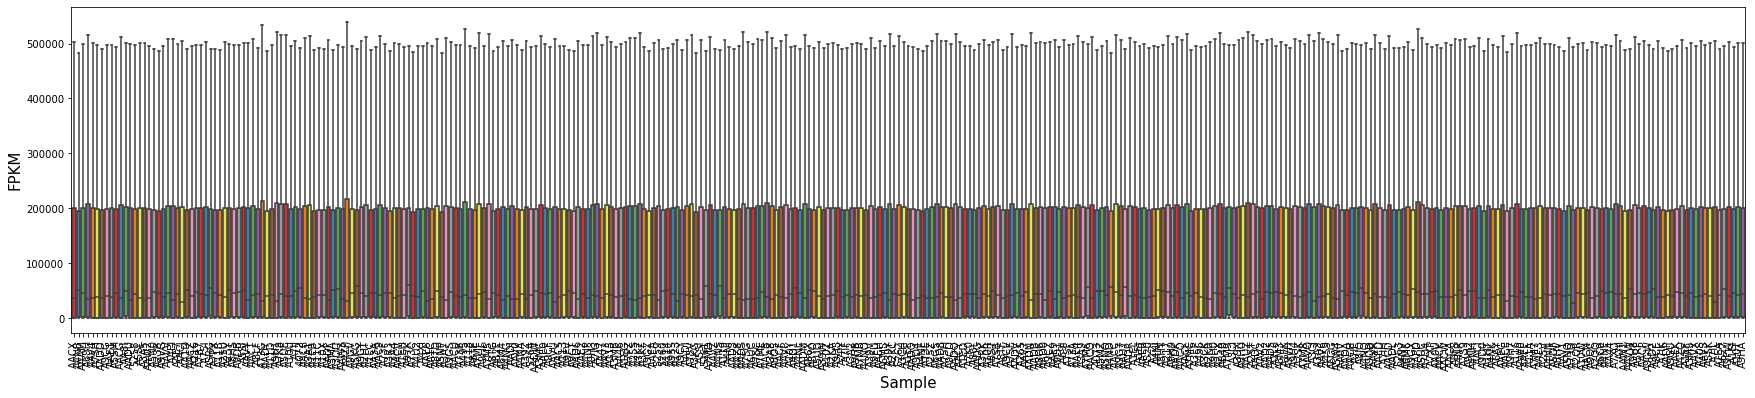

In [6]:
df_boxplot = lihc_df.T
df_boxplot['Sample'] = lihc_df.columns
df_boxplot['HBV'] = sample_df['HBV'].values
df_boxplot = df_boxplot.melt(id_vars= ['Sample','HBV'])
df_boxplot.columns = ['Sample','HBV','Gene','FPKM']

plt.figure(figsize=(30,6))
p = sns.boxplot(data=df_boxplot,x='Sample',y='FPKM',palette='Set1',showfliers = False,showmeans = False)
plt.xticks(rotation=90)
plt.xlabel('Sample',fontsize = 15)
plt.ylabel('FPKM',fontsize = 15)

output_path = path + 'tmp/'
if os.path.exists(output_path) == False :
    os.mkdir(output_path)
#plt.savefig(output_path + 'lihc_hbv_associated_gene_boxplot_before_standardization.png',dpi = 300)


In [ ]:
from scipy import stats
pvalue = np.zeros(103)
for idx,x in enumerate(set(df_boxplot['Gene'])) :
    negative = df_boxplot[(df_boxplot['Gene'] == x) & (df_boxplot['HBV'] == 'Negative')]['value']
    positive = df_boxplot[(df_boxplot['Gene'] == x) & (df_boxplot['HBV'] == 'Positive')]['value']
    p = stats.ttest_ind(negative,positive)
    pvalue[idx] = p[1]
p_df = pd.DataFrame({'Gene' : list(set(df_boxplot['Gene'])),'p-values' : pvalue})

In [7]:
#principle component analysis before standardization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
#subset expression profile
idx = [x.split('.')[0] in ens_id for x in lihc_df.index]
lihc_hbv = lihc_df.loc[idx,:]
#lihc_hbv = lihc_hbv.iloc[:,:355]
hbv_pca = pca.fit(lihc_hbv).transform(lihc_hbv)

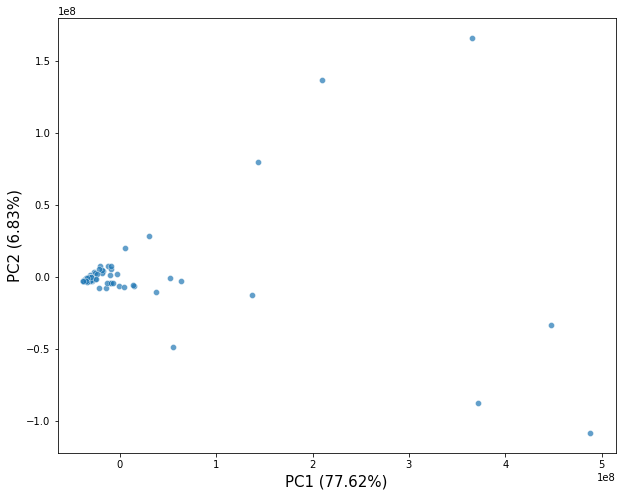

In [9]:
pca_df = pd.DataFrame()
pca_df['PC1'] = hbv_pca[:,0]
pca_df['PC2'] = hbv_pca[:,1]
pc1_explanation = str(round(pca.explained_variance_ratio_[0] * 100,2))
pc2_explanation = str(round(pca.explained_variance_ratio_[1] * 100,2))

plt.figure(figsize=(10,8))
p = sns.scatterplot(data=pca_df,x='PC1',y='PC2',alpha=0.7)
p.set_xlabel('PC1 (' + pc1_explanation + '%)',fontsize = 15)
p.set_ylabel('PC2 (' + pc2_explanation + '%)',fontsize = 15)
output_path = path + 'tmp/'
if os.path.exists(output_path) == False :
    os.mkdir(output_path)
#plt.savefig(output_path + 'lihc_hbv_associated_gene_pca_before_standardization.png',dpi = 300)

In [ ]:
scc = lihc_hbv.T.corr(method='spearman')
plt.figure(figsize=(15,12))
sns.clustermap(scc,cmap="YlGnBu", cbar_pos=(-.1, .2, .03, .4))
#plt.title('HBV associated gene spearman corelation heatmap',fontsize = 20)
plt.savefig(output_path+'lihc_hbv_associated_gene_scc_heatmap.png',dpi = 300)
plt.show()

### Standardization

In [4]:
#standardization
lihc_hbv_array = lihc_df.T.to_numpy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(lihc_hbv_array)
lihc_df_stand = scaler.transform(lihc_hbv_array)

In [5]:
#subset hbv associated gene 
idx = [x.split('.')[0] in ens_id for x in lihc_df.index]
lihc_hbv_array_stand = lihc_df_stand.T[idx,:]
#principle component analysis after standardization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
hbv_pca = pca.fit(lihc_hbv_array_stand).transform(lihc_hbv_array_stand)


/home/bruce1996/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


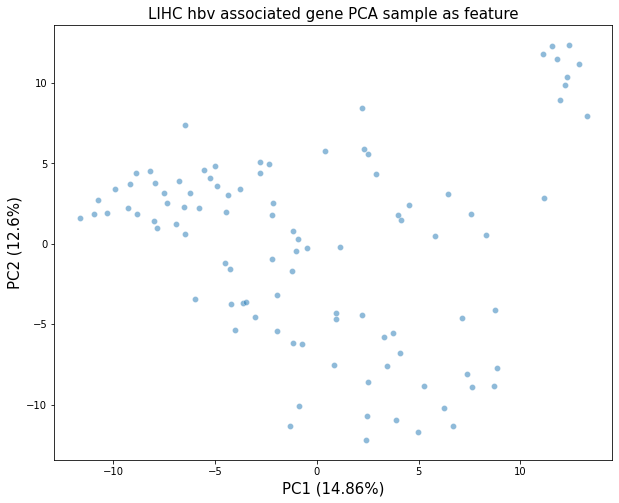

<Figure size 1080x864 with 0 Axes>

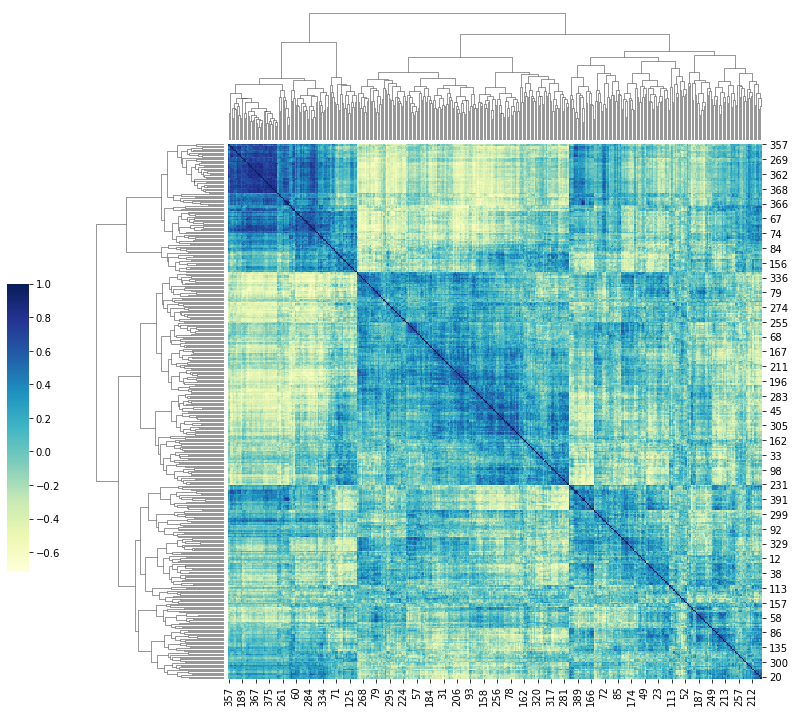

In [6]:
pca_df = pd.DataFrame()
pca_df['PC1'] = hbv_pca[:,0]
pca_df['PC2'] = hbv_pca[:,1]
pc1_explanation = str(round(pca.explained_variance_ratio_[0] * 100,2))
pc2_explanation = str(round(pca.explained_variance_ratio_[1] * 100,2))

plt.figure(figsize=(10,8))
p = sns.scatterplot(data=pca_df,x='PC1',y='PC2',alpha=0.5)
p.set_xlabel('PC1 (' + pc1_explanation + '%)',fontsize = 15)
p.set_ylabel('PC2 (' + pc2_explanation + '%)',fontsize = 15)
plt.title('LIHC hbv associated gene PCA sample as feature',fontsize = 15)
output_path = path + 'tmp/'
if os.path.exists(output_path) == False :
    os.mkdir(output_path)
#plt.savefig(output_path + 'lihc_hbv_associated_gene_pca_after_standardization.png',dpi = 300)


lihc_hbv_stand = pd.DataFrame(lihc_hbv_array_stand)
scc = lihc_hbv_stand.corr(method='spearman')
plt.figure(figsize=(15,12))
sns.clustermap(scc,cmap="YlGnBu", cbar_pos=(-.1, .2, .03, .4))
#plt.title('HBV associated gene spearman corelation heatmap',fontsize = 20)
plt.savefig(output_path+'lihc_hbv_associated_gene_scc_heatmap_after_standardization.png',dpi = 300)
plt.show()

### OCSVM

In [7]:
from sklearn.svm import OneClassSVM

In [8]:
X = lihc_hbv_array_stand
test_idx = [x.split('.')[0] not in ens_id for x in lihc_df.index]
x_test = lihc_df_stand.T[test_idx,:]
ocsvm = OneClassSVM(gamma='scale',kernel='rbf').fit(X)

In [13]:
label = ocsvm.predict(X)
distance = ocsvm.decision_function(X)

Text(0.5, 1.0, 'LIHC anomaly detection by One class SVM (Number of inliner : 51)')

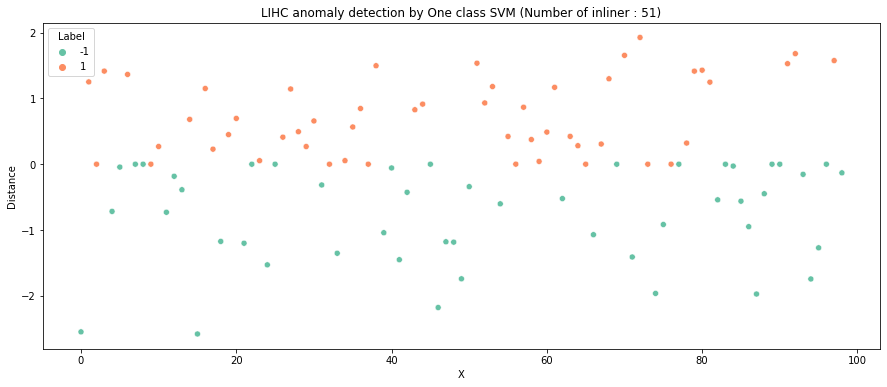

In [15]:
xaxis = np.arange(len(distance))
y = distance
df = pd.DataFrame({'X' : xaxis,'Distance' : distance,'Label' : label})
plt.figure(figsize=(15,6))
sns.scatterplot(data = df,x = 'X',y = 'Distance',hue='Label',palette='Set2')
n_inliner = sum(label == 1)
plt.title('LIHC anomaly detection by One class SVM (Number of inliner : %d)' %n_inliner)
#plt.savefig(output_path + 'lihc_ae_by_ocsvm.png',dpi = 300)

In [51]:
inliner_idx = label == 1
other_gene = lihc_df.index[test_idx]
inliner =  other_gene[inliner_idx]
lihc_target_gene = list(ens_id) + list(inliner)

In [54]:
idx = [x.split('.')[0] in ens_id for x in lihc_df.index]
lihc_hbv_associated_stand = lihc_df_stand.T[idx,:]
#principle component analysis after standardization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
hbv_pca = pca.fit(lihc_hbv_associated_stand).transform(lihc_hbv_associated_stand)

/home/bruce1996/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


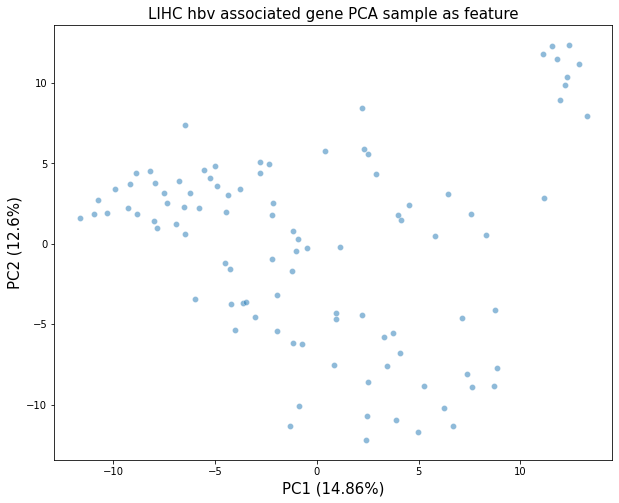

<Figure size 1080x864 with 0 Axes>

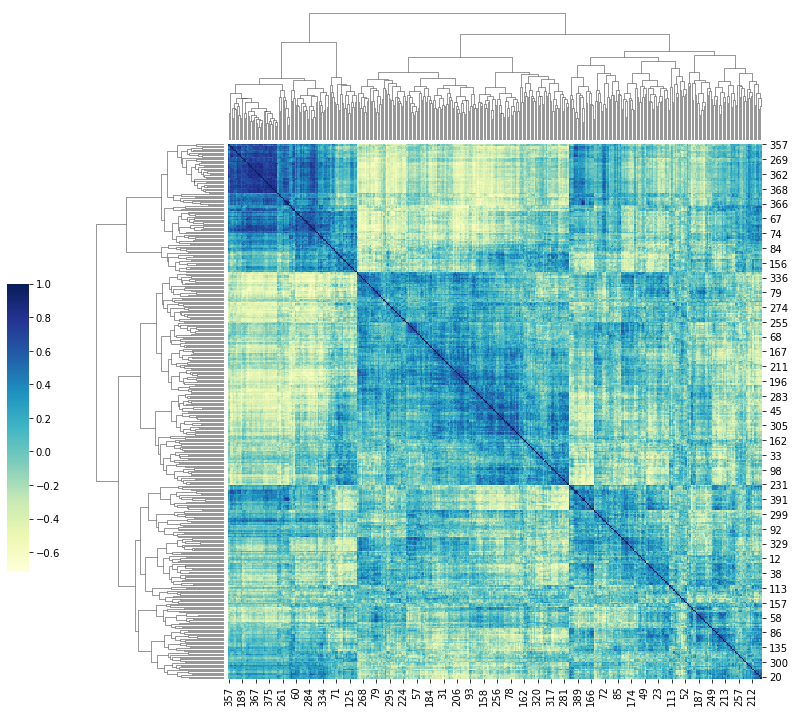

In [55]:
pca_df = pd.DataFrame()
pca_df['PC1'] = hbv_pca[:,0]
pca_df['PC2'] = hbv_pca[:,1]
pc1_explanation = str(round(pca.explained_variance_ratio_[0] * 100,2))
pc2_explanation = str(round(pca.explained_variance_ratio_[1] * 100,2))

plt.figure(figsize=(10,8))
p = sns.scatterplot(data=pca_df,x='PC1',y='PC2',alpha=0.5)
p.set_xlabel('PC1 (' + pc1_explanation + '%)',fontsize = 15)
p.set_ylabel('PC2 (' + pc2_explanation + '%)',fontsize = 15)
plt.title('LIHC hbv associated gene PCA sample as feature',fontsize = 15)
output_path = path + 'tmp/'
if os.path.exists(output_path) == False :
    os.mkdir(output_path)
#plt.savefig(output_path + 'lihc_hbv_associated_gene_pca_after_standardization.png',dpi = 300)


lihc_hbv_stand = pd.DataFrame(lihc_hbv_associated_stand)
scc = lihc_hbv_stand.corr(method='spearman')
plt.figure(figsize=(15,12))
sns.clustermap(scc,cmap="YlGnBu", cbar_pos=(-.1, .2, .03, .4))
#plt.title('HBV associated gene spearman corelation heatmap',fontsize = 20)
plt.savefig(output_path+'lihc_hbv_associated_gene_scc_heatmap_after_standardization.png',dpi = 300)
plt.show()

### SVDD